In [4]:
import slim_conservation_scoring.seqtools.general_utils as tools
import pandas as pd
import numpy as np
import slim_conservation_scoring.pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"

# %load_ext autoreload
# %autoreload 2

# Plotting score distributions

In [19]:
zscores = pd.read_csv('./z_scores_wideform.csv')
score_key = pd.read_csv('./z_scores_score_key.csv')
score_indexes=[i for i in zscores.columns if i in score_key['score_index'].unique()]

from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

zscores['mask_array'] = zscores['mask_array'].str.replace(' ', ',')
zscores['mask_array'] = zscores['mask_array'].apply(literal_eval)

## remove TRAF6 (not enough true positives)

In [20]:
zscores=zscores[zscores['ELM_motif_class']!='TRAF6']
zscores['verified interaction'].value_counts()

verified interaction
False    1701
True      260
Name: count, dtype: int64

## Melt the dataframe

In [21]:
id_cols = [
    'reference_index',
    'ELM_motif_class',
    'verified interaction',
    'regex',
    'UniprotID',
    'name',
    'gene_id',
    'hit end position',
    'hit start position',
    'hit_sequence',
    'json_file',
    'hit_length',
    'mask_array',
]
z_long = zscores.melt(id_vars=id_cols, value_vars=score_indexes, var_name='score_index', value_name='z_scores')

## average scores over motif positions to get a single score for each motif

In [22]:
def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

In [23]:
z_long['masked_z_scores'] = z_long.apply(lambda x: extract_important_scores(x, 'z_scores'), axis=1)
z_long['conservation_score'] = z_long['masked_z_scores'].apply(np.mean)
z_long.sample(5)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,json_file,hit_length,mask_array,score_index,z_scores,masked_z_scores,conservation_score
23734,265,LIG_AP2alpha_2,False,DP[FW],A0A384NY94,NaN,9606_0:00252a,690,688,DPF,/home/jch/Documents/08-benchmark/benchmark/ben...,3,"[1, 1, 1]",35.0,"[-0.7169484147072498, 0.5260626977583535, -1.7...","[-0.7169484147072498, 0.5260626977583535, -1.7...",-0.656497
16092,522,LIG_EH_1,False,.NPF.,Q9H201,NaN,9606_0:003dea,526,522,RNPFL,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[0, 1, 1, 1, 0]",27.0,"[-0.6817916945114822, 0.4528170358868069, 0.11...","[0.4528170358868069, 0.11838123805331799, 1.45...",0.676515
19558,2615,Ena/VASP ([FL]PPPP),False,[FL]PPPP,A0A140VJZ9,NaN,9606_0:000b48,360,356,LPPPP,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[1, 1, 0, 1, 1]",30.0,"[0.7046898116074453, 1.0058395557599351, 1.005...","[0.7046898116074453, 1.0058395557599351, 0.704...",0.811755
28887,1970,LIG_14-3-3_CanoR_1,True,"R[^DE]{0,2}[^DEPG]([ST])(([FWYLMV].)|([^PRIKGN...",Q61097,NaN,10090_0:003b90,393,387,RRTESVP,/home/jch/Documents/08-benchmark/benchmark/ben...,7,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",39.0,"[-0.5880365834143791, -0.47719608854742795, -0...","[-0.5880365834143791, -0.47719608854742795, -0...",-0.409769
10168,472,LIG_EH_1,False,.NPF.,E7EVZ1,NaN,9606_0:0022a1,2913,2909,PNPFG,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[0, 1, 1, 1, 0]",19.0,"[0.8241319694458558, -0.38208919487023624, -0....","[-0.38208919487023624, -0.6289829163282374, 0....",-0.172826


## basic score distribution at Metazoa

In [24]:
temp=pd.merge(z_long, score_key, on='score_index', how='left')
temp = temp[temp['score_key'].isin(['aln_property_entropy', 'pairk_aln_lf0_rf0_edssmat50'])]
temp=temp[temp['level']=='Metazoa']

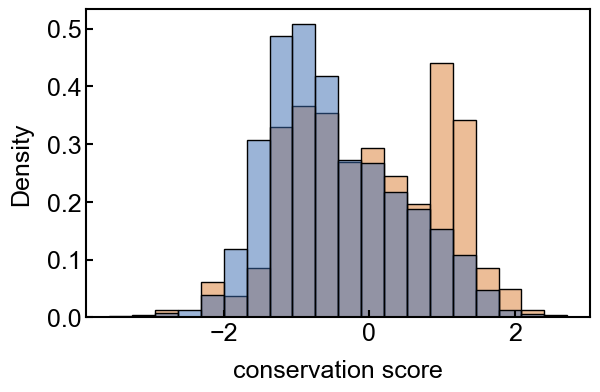

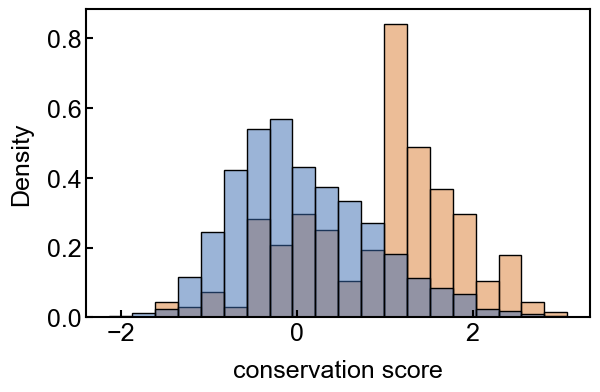

In [26]:
for i in temp['score_key'].unique():
    fig, ax = plt.subplots(figsize=(6.5, 4))
    sns.histplot(
        temp[temp['score_key']==i],
        x="conservation_score",
        hue="verified interaction",
        bins=20,
        stat="density",
        common_norm=False,
        ax=ax,
        legend=False,
    )
    ax.set_xticks([-2, 0, 2])
    ax.set_xlabel('conservation score')
    plt.savefig(f'./figure3/{i}_conservation_score_hist.png', bbox_inches='tight', dpi=300)
    # increase ymax by 0.1
    # ax.set_ylim(0, ax.get_ylim()[1]*1.1)

## basic score distributions vs. level

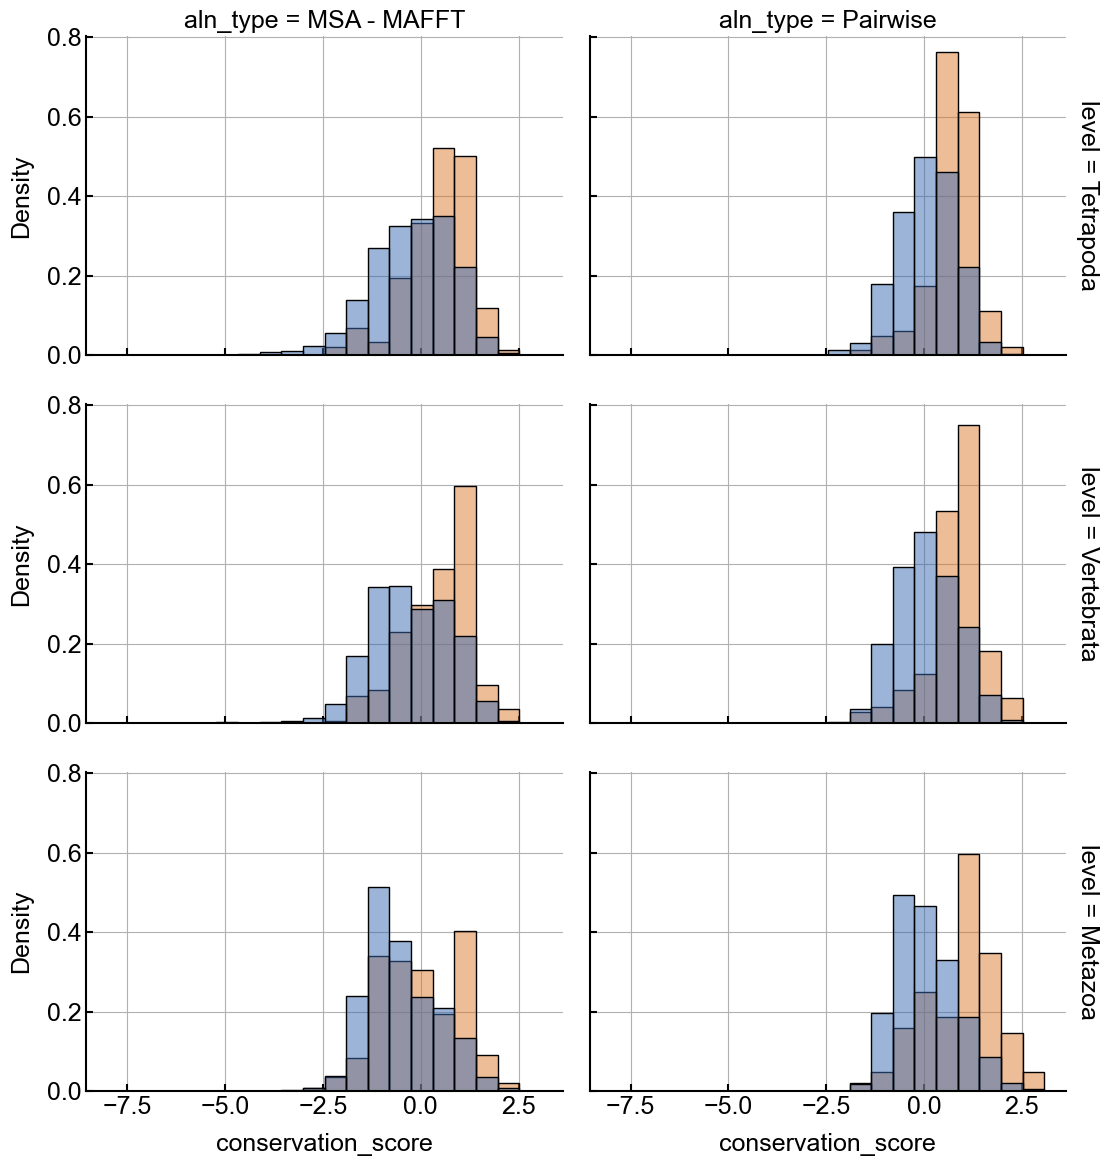

In [27]:
temp=pd.merge(z_long, score_key, on='score_index', how='left')
temp = temp[temp['score_key'].isin(['aln_property_entropy', 'pairk_aln_lf0_rf0_edssmat50'])]
temp['reference_index'].value_counts().head(1)
p = sns.displot(
    temp,
    x="conservation_score",
    hue="verified interaction",
    col="aln_type",
    row="level",
    # bins=np.linspace(-4,4,40),
    bins=20,
    stat="density",
    common_norm=False,
    col_order=["MSA - MAFFT", "Pairwise"],#, "Pairwise embedding"],
    height=4,
    aspect=1.5,
    facet_kws=dict(margin_titles=True),
    common_bins=True,
)
# plt.xlim([-4, 4])
p._legend.remove()
p.set_titles(f"Level: {{row_name}}\nAln type: {{col_name}}")
# show grid lines
for ax in p.axes.flat:
    ax.grid(True)
    ax.set_axisbelow(True)
output_folder = Path('./supplement/score_distributions')
output_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(output_folder / 'benchmark_score_distros_msa_v_pair.png', bbox_inches='tight', dpi=400)